<a href="https://colab.research.google.com/github/moussaouiAGI/modelisation_stochastique/blob/main/modelisation_stochastique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aperçu des données simulées:
                        Date         PIB   Inflation   Chomage       Bourse  \
0 2025-08-24 21:29:38.883439  100.000000  100.000000  7.500000  5000.000000   
1 2025-08-25 21:29:38.883439   99.219926   99.918446  7.551231  4536.749295   
2 2025-08-26 21:29:38.883439   99.938879   99.970139  7.488908  4919.255604   
3 2025-08-27 21:29:38.883439  100.884506   99.817113  7.464413  5347.893722   
4 2025-08-28 21:29:38.883439  101.778043  100.176141  7.458296  5818.020433   

   Taux_Interet  
0      2.000000  
1      2.040316  
2      2.028083  
3      2.031790  
4      2.015226  

Statistiques descriptives:
                                Date          PIB    Inflation      Chomage  \
count                           1825  1825.000000  1825.000000  1825.000000   
mean   2028-02-22 21:29:38.883439360    76.356192   107.494299     7.487591   
min       2025-08-24 21:29:38.883439    57.424664    98.357957     7.178179   
25%    2026-11-23 21:29:38.883439104    66.9

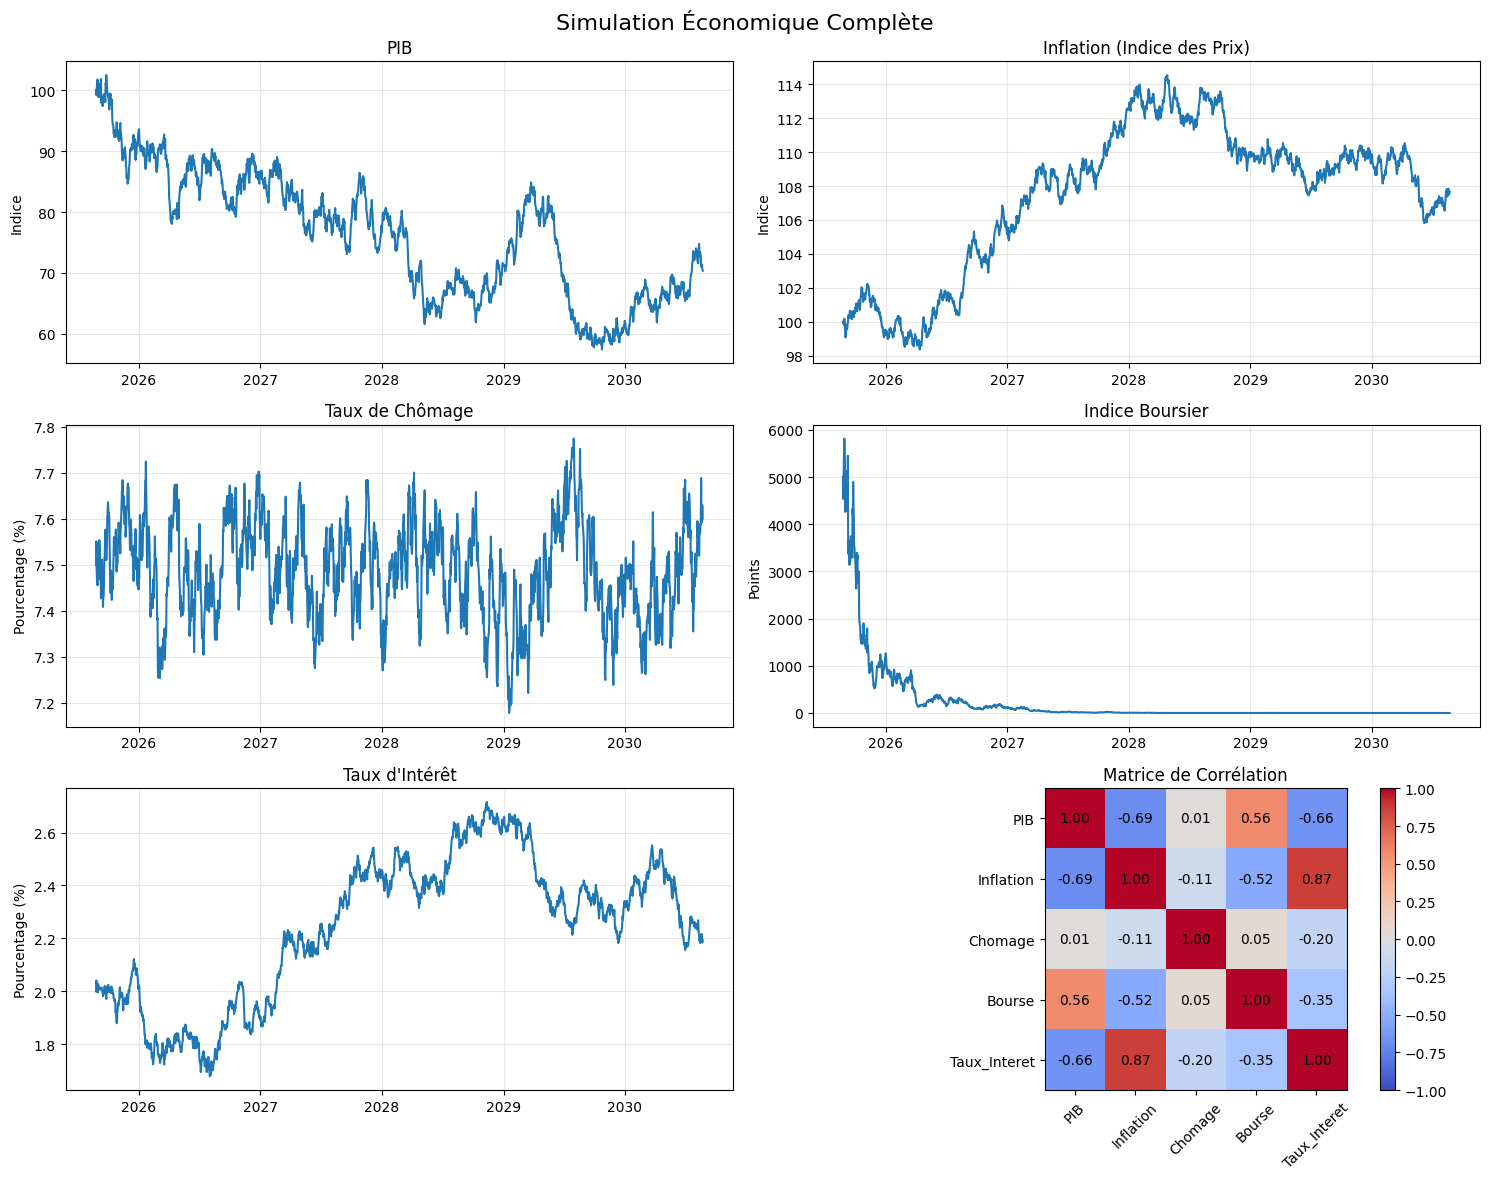


Statistiques détaillées:
              Valeur_Initiale  Valeur_Finale  Rendement_Total  \
PIB                     100.0      70.352811       -29.647189   
Inflation               100.0     107.655034         7.655034   
Chomage                   7.5       7.600949         1.345993   
Bourse                 5000.0       0.026753       -99.999465   
Taux_Interet              2.0       2.192188         9.609424   

              Rendement_Annualise  Volatilite_Annuelle      Maximum  \
PIB                     -6.791334            19.777229   102.503281   
Inflation                1.486171             3.746209   114.546734   
Chomage                  0.267761             9.177147     7.774777   
Bourse                 -91.175723           197.572876  5818.020433   
Taux_Interet             1.852004            13.155221     2.715649   

                Minimum     Moyenne  
PIB           57.424664   76.356192  
Inflation     98.357957  107.494299  
Chomage        7.178179    7.487591  
Bour

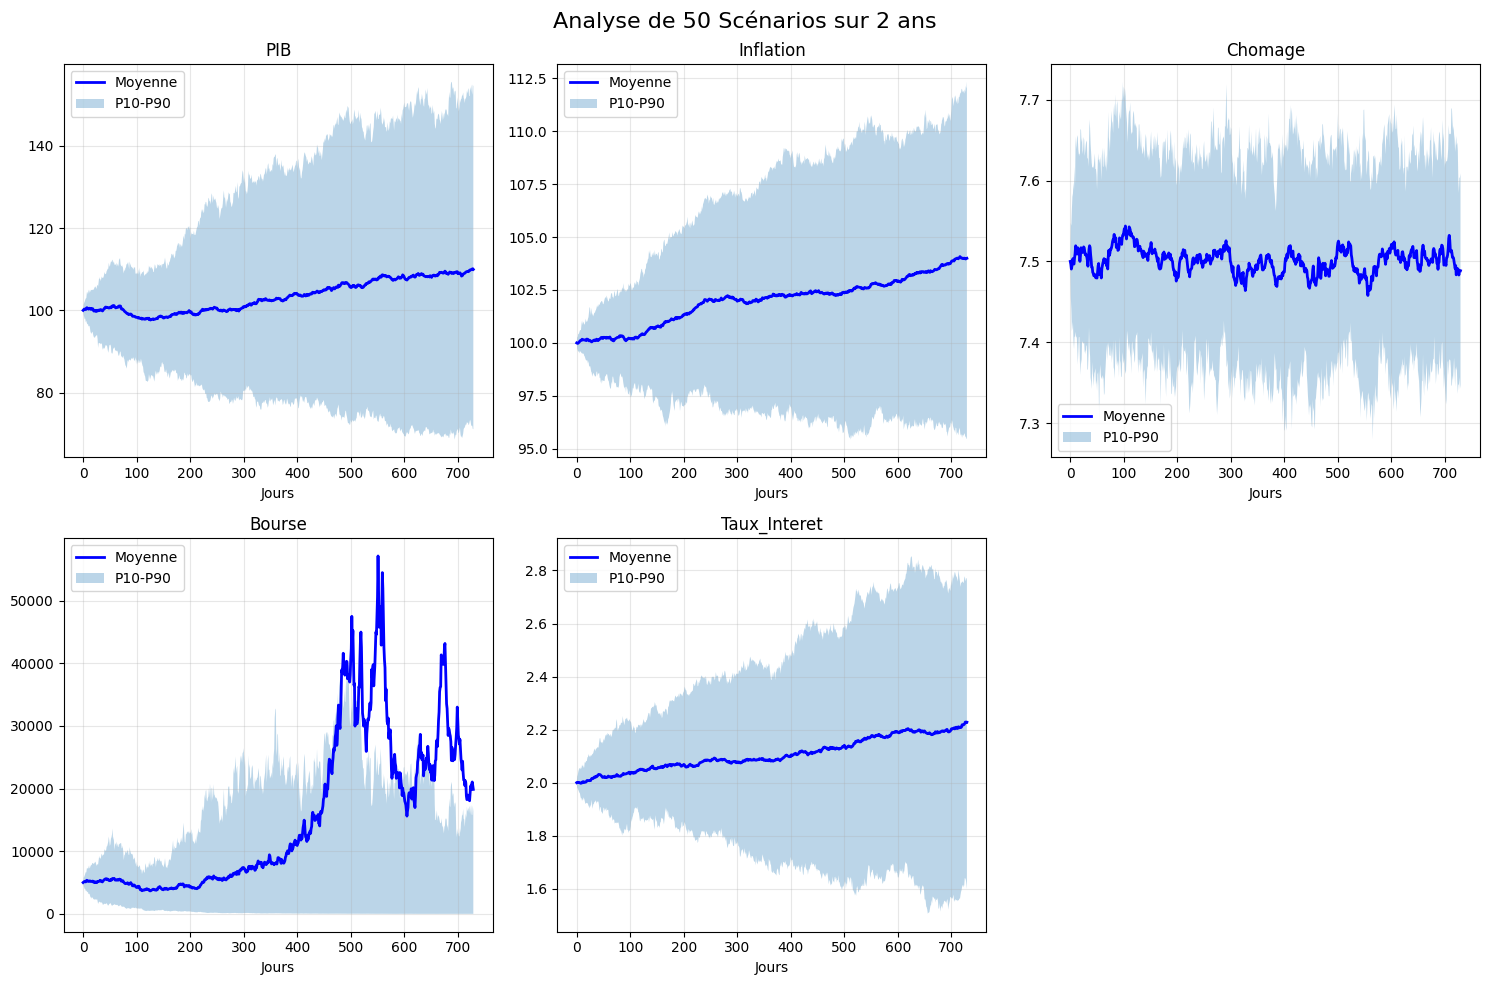

Fichiers exportés: simulation_economique.csv, simulation_economique_statistiques.csv, simulation_economique_parametres.json


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import json

class SimulateurEconomique:
    def __init__(self):
        self.donnees = {}
        self.parametres = {
            'PIB': {'valeur_initiale': 100, 'croissance': 0.03/365, 'volatilite': 0.01},
            'Inflation': {'valeur_initiale': 100, 'moyenne': 0.02/365, 'volatilite': 0.002},
            'Chomage': {'valeur_initiale': 7.5, 'moyenne': 7.5, 'volatilite': 0.5, 'inertie': 0.95},
            'Bourse': {'valeur_initiale': 5000, 'rendement': 0.07/365, 'volatilite': 0.15/np.sqrt(365)},
            'Taux_Interet': {'valeur_initiale': 2.0, 'moyenne': 2.5, 'vitesse_retour': 0.1, 'volatilite': 0.3}
        }

    def simuler_pib(self, n_jours):
        pib = np.zeros(n_jours)
        pib[0] = self.parametres['PIB']['valeur_initiale']

        for t in range(1, n_jours):
            choc = np.random.normal(0, self.parametres['PIB']['volatilite'])
            croissance = self.parametres['PIB']['croissance'] + choc
            pib[t] = pib[t-1] * (1 + croissance)

        return pib

    def simuler_inflation(self, n_jours):
        inflation = np.zeros(n_jours)
        inflation[0] = self.parametres['Inflation']['valeur_initiale']

        for t in range(1, n_jours):
            variation = np.random.normal(self.parametres['Inflation']['moyenne'],
                                       self.parametres['Inflation']['volatilite'])
            inflation[t] = inflation[t-1] * (1 + variation)

        return inflation

    def simuler_chomage(self, n_jours, pib):
        chomage = np.zeros(n_jours)
        chomage[0] = self.parametres['Chomage']['valeur_initiale']

        for t in range(1, n_jours):
            tendance_pib = (pib[t] - pib[t-1]) / pib[t-1]
            effet_pib = -50 * tendance_pib

            bruit = np.random.normal(0, self.parametres['Chomage']['volatilite'])

            chomage[t] = (self.parametres['Chomage']['inertie'] * chomage[t-1] +
                         (1 - self.parametres['Chomage']['inertie']) *
                         (self.parametres['Chomage']['moyenne'] + effet_pib + bruit))

            chomage[t] = max(0, min(20, chomage[t]))

        return chomage

    def simuler_bourse(self, n_jours, pib, inflation):
        bourse = np.zeros(n_jours)
        bourse[0] = self.parametres['Bourse']['valeur_initiale']

        for t in range(1, n_jours):
            croissance_pib = (pib[t] - pib[t-1]) / pib[t-1] if t > 0 else 0
            effet_inflation = -0.5 * ((inflation[t] - inflation[t-1]) / inflation[t-1]) if t > 0 else 0

            rendement_ajuste = self.parametres['Bourse']['rendement'] + 10 * croissance_pib + effet_inflation
            choc = np.random.normal(0, self.parametres['Bourse']['volatilite'])

            bourse[t] = bourse[t-1] * (1 + rendement_ajuste + choc)

        return bourse

    def simuler_taux_interet(self, n_jours, inflation):
        taux = np.zeros(n_jours)
        taux[0] = self.parametres['Taux_Interet']['valeur_initiale']

        for t in range(1, n_jours):
            inflation_annuelle = ((inflation[t] / inflation[max(0, t-365)]) - 1) * 100 if t >= 365 else 2
            taux_cible = max(0, min(10, 1.5 * inflation_annuelle))

            retour_moyenne = self.parametres['Taux_Interet']['vitesse_retour'] * (taux_cible - taux[t-1])
            bruit = np.random.normal(0, self.parametres['Taux_Interet']['volatilite'])

            taux[t] = max(0, taux[t-1] + retour_moyenne * (1/365) + bruit * np.sqrt(1/365))

        return taux

    def simuler_economie_complete(self, n_annees=5):
        n_jours = n_annees * 365

        self.donnees['PIB'] = self.simuler_pib(n_jours)
        self.donnees['Inflation'] = self.simuler_inflation(n_jours)
        self.donnees['Chomage'] = self.simuler_chomage(n_jours, self.donnees['PIB'])
        self.donnees['Bourse'] = self.simuler_bourse(n_jours, self.donnees['PIB'], self.donnees['Inflation'])
        self.donnees['Taux_Interet'] = self.simuler_taux_interet(n_jours, self.donnees['Inflation'])

        dates = pd.date_range(start=datetime.now(), periods=n_jours, freq='D')

        self.df_resultats = pd.DataFrame({
            'Date': dates,
            'PIB': self.donnees['PIB'],
            'Inflation': self.donnees['Inflation'],
            'Chomage': self.donnees['Chomage'],
            'Bourse': self.donnees['Bourse'],
            'Taux_Interet': self.donnees['Taux_Interet']
        })

        return self.df_resultats

    def visualiser_resultats(self):
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle('Simulation Économique Complète', fontsize=16)

        axes[0, 0].plot(self.df_resultats['Date'], self.df_resultats['PIB'])
        axes[0, 0].set_title('PIB')
        axes[0, 0].set_ylabel('Indice')
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(self.df_resultats['Date'], self.df_resultats['Inflation'])
        axes[0, 1].set_title('Inflation (Indice des Prix)')
        axes[0, 1].set_ylabel('Indice')
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].plot(self.df_resultats['Date'], self.df_resultats['Chomage'])
        axes[1, 0].set_title('Taux de Chômage')
        axes[1, 0].set_ylabel('Pourcentage (%)')
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].plot(self.df_resultats['Date'], self.df_resultats['Bourse'])
        axes[1, 1].set_title('Indice Boursier')
        axes[1, 1].set_ylabel('Points')
        axes[1, 1].grid(True, alpha=0.3)

        axes[2, 0].plot(self.df_resultats['Date'], self.df_resultats['Taux_Interet'])
        axes[2, 0].set_title('Taux d\'Intérêt')
        axes[2, 0].set_ylabel('Pourcentage (%)')
        axes[2, 0].grid(True, alpha=0.3)

        correlations = self.df_resultats[['PIB', 'Inflation', 'Chomage', 'Bourse', 'Taux_Interet']].corr()
        im = axes[2, 1].imshow(correlations, cmap='coolwarm', vmin=-1, vmax=1)
        axes[2, 1].set_xticks(range(5))
        axes[2, 1].set_yticks(range(5))
        axes[2, 1].set_xticklabels(correlations.columns, rotation=45)
        axes[2, 1].set_yticklabels(correlations.columns)
        axes[2, 1].set_title('Matrice de Corrélation')

        for i in range(5):
            for j in range(5):
                axes[2, 1].text(j, i, f'{correlations.iloc[i, j]:.2f}',
                               ha='center', va='center')

        plt.colorbar(im, ax=axes[2, 1])
        plt.tight_layout()
        plt.show()

    def generer_scenarios(self, n_scenarios=100, n_annees=2):
        scenarios = {}

        for variable in ['PIB', 'Inflation', 'Chomage', 'Bourse', 'Taux_Interet']:
            scenarios[variable] = []

        for _ in range(n_scenarios):
            df_scenario = self.simuler_economie_complete(n_annees)
            for variable in scenarios.keys():
                scenarios[variable].append(df_scenario[variable].values)

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'Analyse de {n_scenarios} Scénarios sur {n_annees} ans', fontsize=16)
        axes = axes.flatten()

        for idx, (variable, data) in enumerate(scenarios.items()):
            data_array = np.array(data)
            moyenne = np.mean(data_array, axis=0)
            percentile_10 = np.percentile(data_array, 10, axis=0)
            percentile_90 = np.percentile(data_array, 90, axis=0)

            jours = range(len(moyenne))

            axes[idx].plot(jours, moyenne, 'b-', linewidth=2, label='Moyenne')
            axes[idx].fill_between(jours, percentile_10, percentile_90, alpha=0.3, label='P10-P90')
            axes[idx].set_title(variable)
            axes[idx].set_xlabel('Jours')
            axes[idx].grid(True, alpha=0.3)
            axes[idx].legend()

        axes[-1].axis('off')
        plt.tight_layout()
        plt.show()

        return scenarios

    def calculer_statistiques(self):
        stats = {}

        for col in ['PIB', 'Inflation', 'Chomage', 'Bourse', 'Taux_Interet']:
            serie = self.df_resultats[col]

            rendements = serie.pct_change().dropna()

            stats[col] = {
                'Valeur_Initiale': serie.iloc[0],
                'Valeur_Finale': serie.iloc[-1],
                'Rendement_Total': (serie.iloc[-1] / serie.iloc[0] - 1) * 100,
                'Rendement_Annualise': ((serie.iloc[-1] / serie.iloc[0]) ** (365/len(serie)) - 1) * 100,
                'Volatilite_Annuelle': rendements.std() * np.sqrt(365) * 100,
                'Maximum': serie.max(),
                'Minimum': serie.min(),
                'Moyenne': serie.mean()
            }

        df_stats = pd.DataFrame(stats).T
        return df_stats

    def exporter_resultats(self, nom_fichier='simulation_economique'):
        self.df_resultats.to_csv(f'{nom_fichier}.csv', index=False)

        stats = self.calculer_statistiques()
        stats.to_csv(f'{nom_fichier}_statistiques.csv')

        parametres_json = json.dumps(self.parametres, indent=2)
        with open(f'{nom_fichier}_parametres.json', 'w') as f:
            f.write(parametres_json)

        print(f"Fichiers exportés: {nom_fichier}.csv, {nom_fichier}_statistiques.csv, {nom_fichier}_parametres.json")

simulateur = SimulateurEconomique()

df_economie = simulateur.simuler_economie_complete(n_annees=5)

print("Aperçu des données simulées:")
print(df_economie.head())
print("\nStatistiques descriptives:")
print(df_economie.describe())

simulateur.visualiser_resultats()

stats_finales = simulateur.calculer_statistiques()
print("\nStatistiques détaillées:")
print(stats_finales)

print("\nGénération de scénarios multiples...")
scenarios = simulateur.generer_scenarios(n_scenarios=50, n_annees=2)

simulateur.exporter_resultats()